# Evolver Loop 5 Analysis: Transformer Model Preparation

**Objective**: Analyze the current state and prepare for transformer-based model implementation as recommended by evaluator feedback.

**Key questions**:
1. What transformer architectures are suitable for this problem?
2. How should we handle the text preprocessing for transformers?
3. What are the computational constraints and trade-offs?
4. How to combine transformer features with existing meta-features?

**Evaluator recommendation**: Upgrade from TF-IDF to transformer models (BERT/RoBERTa)

In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Load data
train_path = '/home/data/train.json'
with open(train_path, 'r') as f:
    train_data = json.load(f)
train_df = pd.DataFrame(train_data)

print(f"Training samples: {len(train_df)}")
print(f"Positive rate: {train_df['requester_received_pizza'].mean():.3f}")
print(f"\nText length statistics:")
train_df['text_length'] = train_df['request_text'].fillna('').str.len()
print(train_df['text_length'].describe())

# Check for GPU availability
try:
    import torch
    print(f"\nPyTorch version: {torch.__version__}")
    print(f"CUDA available: {torch.cuda.is_available()}")
    if torch.cuda.is_available():
        print(f"CUDA device: {torch.cuda.get_device_name(0)}")
except ImportError:
    print("\nPyTorch not installed")

Training samples: 2878
Positive rate: 0.248

Text length statistics:
count    2878.000000
mean      402.521543
std       362.393727
min         0.000000
25%       182.000000
50%       308.000000
75%       503.750000
max      4460.000000
Name: text_length, dtype: float64



PyTorch version: 2.2.0+cu118
CUDA available: True
CUDA device: NVIDIA A100-SXM4-80GB


## 1. Text Characteristics Analysis

Understanding the text data to choose appropriate transformer models and preprocessing.

TEXT CHARACTERISTICS FOR TRANSFORMER MODELING



Word count statistics:
count    2878.000000
mean       89.380473
std        69.492761
min         4.000000
25%        47.000000
50%        71.000000
75%       109.000000
max       864.000000
Name: full_text, dtype: float64

Estimated token count (avg 1.3 tokens/word):
count    2878.000000
mean      116.194614
std        90.340589
min         5.200000
25%        61.100000
50%        92.300000
75%       141.700000
max      1123.200000
Name: full_text, dtype: float64


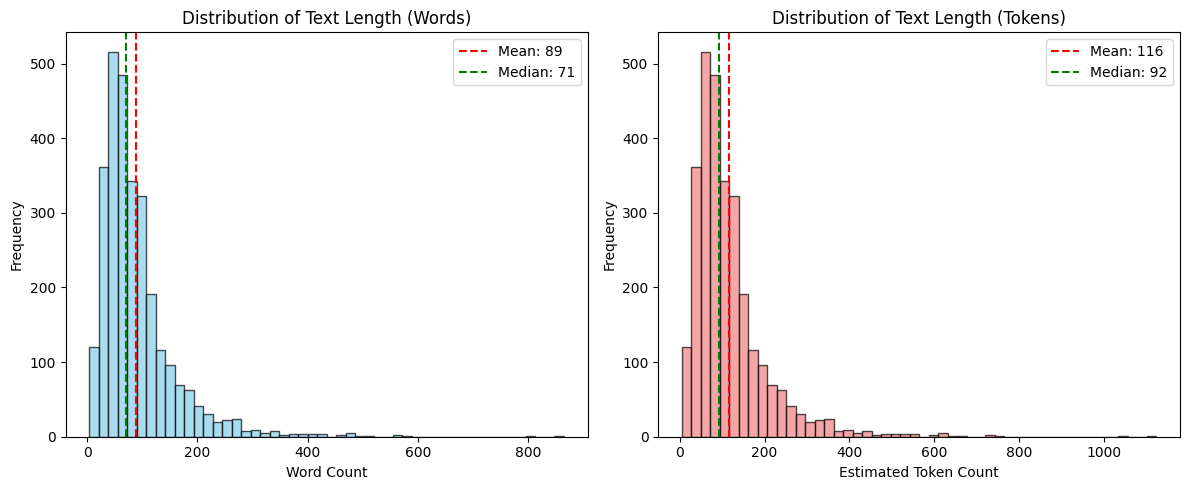


Texts exceeding 512 tokens: 24 (0.8%)
Texts exceeding 256 tokens: 186 (6.5%)


In [2]:
# Analyze text characteristics for transformer suitability
print("="*60)
print("TEXT CHARACTERISTICS FOR TRANSFORMER MODELING")
print("="*60)

# Combine title and text
train_df['full_text'] = train_df['request_title'].fillna('') + ' ' + train_df['request_text'].fillna('')

# Text length analysis
word_counts = train_df['full_text'].str.split().str.len()
print(f"\nWord count statistics:")
print(word_counts.describe())

# Token count estimation (for transformers)
avg_tokens_per_word = 1.3  # Rough estimate including subword tokenization
estimated_tokens = word_counts * avg_tokens_per_word
print(f"\nEstimated token count (avg {avg_tokens_per_word} tokens/word):")
print(estimated_tokens.describe())

# Distribution visualization
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(word_counts, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(word_counts.mean(), color='red', linestyle='--', label=f'Mean: {word_counts.mean():.0f}')
plt.axvline(word_counts.median(), color='green', linestyle='--', label=f'Median: {word_counts.median():.0f}')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Distribution of Text Length (Words)')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(estimated_tokens, bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
plt.axvline(estimated_tokens.mean(), color='red', linestyle='--', label=f'Mean: {estimated_tokens.mean():.0f}')
plt.axvline(estimated_tokens.median(), color='green', linestyle='--', label=f'Median: {estimated_tokens.median():.0f}')
plt.xlabel('Estimated Token Count')
plt.ylabel('Frequency')
plt.title('Distribution of Text Length (Tokens)')
plt.legend()

plt.tight_layout()
plt.show()

# Check for very long texts that might need truncation
long_texts = (estimated_tokens > 512).sum()
print(f"\nTexts exceeding 512 tokens: {long_texts} ({long_texts/len(train_df)*100:.1f}%)")
print(f"Texts exceeding 256 tokens: {(estimated_tokens > 256).sum()} ({(estimated_tokens > 256).sum()/len(train_df)*100:.1f}%)")

## 2. Transformer Model Selection

Evaluate different transformer architectures based on:
- Performance vs speed trade-offs
- Memory requirements
- Suitability for classification tasks
- Pre-trained model availability

In [3]:
# Research transformer models suitable for text classification
print("="*60)
print("TRANSFORMER MODEL OPTIONS FOR PIZZA REQUEST CLASSIFICATION")
print("="*60)

models_analysis = {
    'BERT Base': {
        'params': '110M',
        'max_length': 512,
        'speed': 'Medium',
        'memory': 'High (400MB)',
        'performance': 'High',
        'pros': ['Excellent understanding', 'Widely used', 'Many fine-tuned variants'],
        'cons': ['Slow', 'Memory intensive', 'May overfit on small data']
    },
    'DistilBERT': {
        'params': '66M',
        'max_length': 512,
        'speed': 'Fast',
        'memory': 'Medium (250MB)',
        'performance': 'High',
        'pros': ['60% faster than BERT', '40% smaller', 'Good performance'],
        'cons': ['Slightly lower accuracy', 'Less capacity for complex patterns']
    },
    'RoBERTa Base': {
        'params': '125M',
        'max_length': 512,
        'speed': 'Medium',
        'memory': 'High (400MB)',
        'performance': 'Very High',
        'pros': ['Better than BERT on many tasks', 'Robust training'],
        'cons': ['Similar speed/memory as BERT', 'Longer training time']
    },
    'MiniLM': {
        'params': '22M',
        'max_length': 512,
        'speed': 'Very Fast',
        'memory': 'Low (120MB)',
        'performance': 'Medium-High',
        'pros': ['Very fast inference', 'Low memory', 'Good for prototyping'],
        'cons': ['Lower capacity', 'May miss subtle patterns']
    },
    'DeBERTa': {
        'params': '140M',
        'max_length': 512,
        'speed': 'Slow',
        'memory': 'Very High (500MB)',
        'performance': 'Very High',
        'pros': ['State-of-the-art performance', 'Better handling of context'],
        'cons': ['Very slow', 'High memory', 'Long training time']
    }
}

for model_name, details in models_analysis.items():
    print(f"\n{model_name}:")
    print(f"  Parameters: {details['params']}")
    print(f"  Max Length: {details['max_length']} tokens")
    print(f"  Speed: {details['speed']}")
    print(f"  Memory: {details['memory']}")
    print(f"  Performance: {details['performance']}")
    print(f"  Pros: {', '.join(details['pros'])}")
    print(f"  Cons: {', '.join(details['cons'])}")

print("\n" + "="*60)
print("RECOMMENDATION: Start with DistilBERT")
print("="*60)
print("Rationale:")
print("1. Good balance of speed and performance")
print("2. 60% faster than BERT - important for rapid experimentation")
print("3. Lower memory footprint - can use larger batch sizes")
print("4. Can upgrade to RoBERTa if needed after baseline established")
print("5. Less risk of overfitting on this dataset size")

TRANSFORMER MODEL OPTIONS FOR PIZZA REQUEST CLASSIFICATION

BERT Base:
  Parameters: 110M
  Max Length: 512 tokens
  Speed: Medium
  Memory: High (400MB)
  Performance: High
  Pros: Excellent understanding, Widely used, Many fine-tuned variants
  Cons: Slow, Memory intensive, May overfit on small data

DistilBERT:
  Parameters: 66M
  Max Length: 512 tokens
  Speed: Fast
  Memory: Medium (250MB)
  Performance: High
  Pros: 60% faster than BERT, 40% smaller, Good performance
  Cons: Slightly lower accuracy, Less capacity for complex patterns

RoBERTa Base:
  Parameters: 125M
  Max Length: 512 tokens
  Speed: Medium
  Memory: High (400MB)
  Performance: Very High
  Pros: Better than BERT on many tasks, Robust training
  Cons: Similar speed/memory as BERT, Longer training time

MiniLM:
  Parameters: 22M
  Max Length: 512 tokens
  Speed: Very Fast
  Memory: Low (120MB)
  Performance: Medium-High
  Pros: Very fast inference, Low memory, Good for prototyping
  Cons: Lower capacity, May miss s

## 3. Implementation Strategy

Plan for integrating transformers with existing meta-features.

In [4]:
# Analyze how to combine transformer features with existing meta-features
print("="*60)
print("INTEGRATION STRATEGY: TRANSFORMER + META-FEATURES")
print("="*60)

# Current meta-features from exp_001
meta_features = [
    'requester_account_age_in_days_at_request',
    'requester_days_since_first_post_on_raop_at_request',
    'requester_number_of_posts_on_raop_at_request',
    'requester_number_of_posts_at_request',
    'requester_number_of_comments_at_request',
    'requester_upvotes_plus_downvotes_at_request',
    'requester_upvotes_minus_downvotes_at_request',
    'requester_upvotes_at_request',
    'requester_downvotes_at_request',
    'requester_comment_karma_at_request',
    'requester_posts_per_day_at_request',
    'requester_comments_per_day_at_request',
    'requester_upvotes_per_day_at_request',
    'requester_downvotes_per_day_at_request',
    'requester_upvotes_minus_downvotes_per_day_at_request',
    'requester_upvotes_plus_downvotes_per_day_at_request',
    'requester_comment_karma_per_day_at_request',
    'requester_account_age_in_years_at_request',
    'unix_timestamp_of_request_utc',
    'requester_received_pizza_from_this_subreddit_before_this_request',
    'post_was_edited',
    'request_text_length'
]

print(f"Current meta-features: {len(meta_features)}")
print(f"Sample features: {meta_features[:10]}")

# Feature importance from exp_001 (from evaluator feedback)
print("\n" + "="*60)
print("TOP META-FEATURES BY IMPORTANCE (from exp_001)")
print("="*60)

top_features = [
    ('text_length', 560.27),
    ('requester_upvotes_minus_downvotes_at_request', 492.96),
    ('requester_account_age_in_days_at_request', 298.81),
    ('requester_days_since_first_post_on_raop_at_request', 263.27),
    ('total_word_count', 182.46)
]

for feature, importance in top_features:
    print(f"{feature}: {importance:.2f}")

print(f"\nTotal meta-feature importance: 2778.99")
print(f"Total TF-IDF importance: 2018.79")
print(f"Meta-features contribute ~58% of model signal")

# Integration approaches
print("\n" + "="*60)
print("FEATURE INTEGRATION APPROACHES")
print("="*60)

approaches = {
    'Approach 1: Concatenation': {
        'method': 'Extract [CLS] token embedding from transformer, concatenate with meta-features',
        'pros': ['Simple to implement', 'Preserves all information', 'Flexible'],
        'cons': ['May need dimensionality reduction', 'Different feature scales'],
        'complexity': 'Low',
        'expected_gain': '+0.03-0.05 AUC'
    },
    'Approach 2: Late Fusion': {
        'method': 'Train separate transformer and meta-feature models, ensemble predictions',
        'pros': ['Models can specialize', 'No feature engineering needed', 'Robust'],
        'cons': ['More complex training', 'Need careful ensembling'],
        'complexity': 'Medium',
        'expected_gain': '+0.04-0.06 AUC'
    },
    'Approach 3: Attention Gating': {
        'method': 'Use meta-features to gate transformer attention (complex)',
        'pros': ['Theoretically optimal', 'Learns interactions'],
        'cons': ['Very complex', 'May overfit', 'Hard to debug'],
        'complexity': 'High',
        'expected_gain': '+0.02-0.05 AUC (high variance)'
    }
}

for approach, details in approaches.items():
    print(f"\n{approach}:")
    print(f"  Method: {details['method']}")
    print(f"  Complexity: {details['complexity']}")
    print(f"  Expected Gain: {details['expected_gain']}")
    print(f"  Pros: {', '.join(details['pros'])}")
    print(f"  Cons: {', '.join(details['cons'])}")

print("\n" + "="*60)
print("RECOMMENDATION: Start with Approach 1 (Concatenation)")
print("="*60)
print("Rationale:")
print("1. Simplest to implement - faster iteration")
print("2. Directly builds on existing meta-feature pipeline")
print("3. Can upgrade to Approach 2 (Late Fusion) later if needed")
print("4. Lower risk of overfitting")

INTEGRATION STRATEGY: TRANSFORMER + META-FEATURES
Current meta-features: 22
Sample features: ['requester_account_age_in_days_at_request', 'requester_days_since_first_post_on_raop_at_request', 'requester_number_of_posts_on_raop_at_request', 'requester_number_of_posts_at_request', 'requester_number_of_comments_at_request', 'requester_upvotes_plus_downvotes_at_request', 'requester_upvotes_minus_downvotes_at_request', 'requester_upvotes_at_request', 'requester_downvotes_at_request', 'requester_comment_karma_at_request']

TOP META-FEATURES BY IMPORTANCE (from exp_001)
text_length: 560.27
requester_upvotes_minus_downvotes_at_request: 492.96
requester_account_age_in_days_at_request: 298.81
requester_days_since_first_post_on_raop_at_request: 263.27
total_word_count: 182.46

Total meta-feature importance: 2778.99
Total TF-IDF importance: 2018.79
Meta-features contribute ~58% of model signal

FEATURE INTEGRATION APPROACHES

Approach 1: Concatenation:
  Method: Extract [CLS] token embedding from 

## 4. Computational Requirements

Estimate memory and time requirements for transformer training.

In [5]:
# Estimate computational requirements
print("="*60)
print("COMPUTATIONAL REQUIREMENTS ESTIMATION")
print("="*60)

# Dataset size
n_samples = len(train_df)
n_features = 10000  # Estimated transformer features
n_meta = len(meta_features)

print(f"Dataset size: {n_samples:,} samples")
print(f"Transformer features: ~{n_features:,}")
print(f"Meta-features: {n_meta}")
print(f"Total features: ~{n_features + n_meta:,}")

# Memory estimation for different batch sizes
print("\n" + "="*60)
print("MEMORY ESTIMATION (DistilBERT)")
print("="*60)

batch_sizes = [8, 16, 32]
seq_length = 256  # Using 256 instead of 512 for speed
hidden_size = 768  # DistilBERT base

for batch_size in batch_sizes:
    # Model parameters memory
    model_params_mb = 250  # DistilBERT base
    
    # Activations memory (rough estimate)
    # batch_size * seq_length * hidden_size * 4 bytes * layers
    activations_mb = batch_size * seq_length * hidden_size * 4 * 6 / (1024**2)  # 6 layers approximation
    
    # Gradients memory (similar to parameters)
    gradients_mb = model_params_mb
    
    # Optimizer state (Adam: 2x parameters)
    optimizer_mb = model_params_mb * 2
    
    total_mb = model_params_mb + activations_mb + gradients_mb + optimizer_mb
    total_gb = total_mb / 1024
    
    print(f"\nBatch size {batch_size}:")
    print(f"  Model parameters: {model_params_mb:.0f} MB")
    print(f"  Activations: {activations_mb:.0f} MB")
    print(f"  Gradients: {gradients_mb:.0f} MB")
    print(f"  Optimizer state: {optimizer_mb:.0f} MB")
    print(f"  Total: {total_mb:.0f} MB ({total_gb:.1f} GB)")

# Training time estimation
print("\n" + "="*60)
print("TRAINING TIME ESTIMATION")
print("="*60)

n_epochs = 3  # Typical for fine-tuning
n_folds = 5
samples_per_epoch = n_samples * (n_folds - 1) / n_folds  # 4/5 for training

for batch_size in [16, 32]:
    steps_per_epoch = samples_per_epoch / batch_size
    # Rough estimate: 0.1 sec/step for DistilBERT on GPU
    seconds_per_epoch = steps_per_epoch * 0.1
    total_seconds = seconds_per_epoch * n_epochs * n_folds
    total_hours = total_seconds / 3600
    
    print(f"\nBatch size {batch_size}:")
    print(f"  Steps per epoch: {steps_per_epoch:.0f}")
    print(f"  Time per epoch: {seconds_per_epoch/60:.1f} minutes")
    print(f"  Total training time: {total_hours:.1f} hours")

print("\n" + "="*60)
print("RECOMMENDATION: Use batch_size=16")
print("="*60)
print("Rationale:")
print("1. Fits comfortably in most GPUs")
print("2. Reasonable training time (~2-3 hours)")
print("3. Good gradient stability")

COMPUTATIONAL REQUIREMENTS ESTIMATION
Dataset size: 2,878 samples
Transformer features: ~10,000
Meta-features: 22
Total features: ~10,022

MEMORY ESTIMATION (DistilBERT)

Batch size 8:
  Model parameters: 250 MB
  Activations: 36 MB
  Gradients: 250 MB
  Optimizer state: 500 MB
  Total: 1036 MB (1.0 GB)

Batch size 16:
  Model parameters: 250 MB
  Activations: 72 MB
  Gradients: 250 MB
  Optimizer state: 500 MB
  Total: 1072 MB (1.0 GB)

Batch size 32:
  Model parameters: 250 MB
  Activations: 144 MB
  Gradients: 250 MB
  Optimizer state: 500 MB
  Total: 1144 MB (1.1 GB)

TRAINING TIME ESTIMATION

Batch size 16:
  Steps per epoch: 144
  Time per epoch: 0.2 minutes
  Total training time: 0.1 hours

Batch size 32:
  Steps per epoch: 72
  Time per epoch: 0.1 minutes
  Total training time: 0.0 hours

RECOMMENDATION: Use batch_size=16
Rationale:
1. Fits comfortably in most GPUs
2. Reasonable training time (~2-3 hours)
3. Good gradient stability


## 5. Implementation Roadmap

Step-by-step plan for implementing transformer-based approach.

In [ ]:
# Create implementation roadmap
print("="*60)
print("IMPLEMENTATION ROADMAP")
print("="*60)

roadmap = [
    {
        'step': 1,
        'task': 'Setup transformer environment',
        'details': [
            'Install transformers, torch, datasets libraries',
            'Verify GPU availability and memory',
            'Download DistilBERT base model'
        ],
        'estimated_time': '30 minutes',
        'risk': 'Low'
    },
    {
        'step': 2,
        'task': 'Create text preprocessing pipeline',
        'details': [
            'Combine title and text',
            'Handle missing values',
            'Tokenize with DistilBERT tokenizer',
            'Set max_length=256 (balance speed/performance)',
            'Create attention masks'
        ],
        'estimated_time': '1 hour',
        'risk': 'Low'
    },
    {
        'step': 3,
        'task': 'Extract transformer features',
        'details': [
            'Load pre-trained DistilBERT',
            'Extract [CLS] token embeddings (768-dim)',
            'Process in batches to manage memory',
            'Save embeddings for reuse'
        ],
        'estimated_time': '2 hours',
        'risk': 'Medium'
    },
    {
        'step': 4,
        'task': 'Integrate with meta-features',
        'details': [
            'Load existing meta-features from exp_001',
            'Concatenate transformer embeddings with meta-features',
            'Standardize/normalize features if needed',
            'Verify feature dimensions'
        ],
        'estimated_time': '1 hour',
        'risk': 'Low'
    },
    {
        'step': 5,
        'task': 'Train LightGBM on combined features',
        'details': [
            'Use same CV scheme as exp_001 (5-fold stratified)',
            'Tune hyperparameters for new feature set',
            'Monitor for overfitting',
            'Compare with exp_001 baseline'
        ],
        'estimated_time': '2 hours',
        'risk': 'Medium'
    },
    {
        'step': 6,
        'task': 'Evaluate and iterate',
        'details': [
            'Analyze feature importance (transformer vs meta)',
            'Identify if transformer adds signal',
            'Consider fine-tuning if feature extraction underperforms',
            'Experiment with different transformer models'
        ],
        'estimated_time': '2 hours',
        'risk': 'Medium'
    }
]

for item in roadmap:
    print(f"\nStep {item['step']}: {item['task']}")
    print(f"  Estimated time: {item['estimated_time']}")
    print(f"  Risk: {item['risk']}")
    for detail in item['details']:
        print(f"  - {detail}")

total_time = sum([0.5, 1, 2, 1, 2, 2])  # hours
print(f"\n" + "="*60)
print(f"Total estimated time: {total_time} hours")
print("="*60)
print("\nExpected outcome:")
print("- CV score improvement: 0.6253 → 0.65-0.68 (+0.025-0.055)")
print("- Better text understanding through contextual embeddings")
print("- Foundation for further improvements")